# Investor Classifier, Part I
Welcome to the tenth lesson! This Jupyter Notebook file is meant to accompany thefile  **L10 - Investor Classifier I.**

| Feature     	| Description                                                                 	|
|:-------------	|:-----------------------------------------------------------------------------	|
| investor    	| Name of investor                                                            	|
| commit      	| Whether investor committed or declined transaction (target variable)        	|
| deal_size   	| Total size of transaction (\$ in MM)                                         	|
| invite      	| Amount individual investor was invited to commit (\$ in MM)                  	|
| rating      	| Client Moody's credit rating converted to continuous values                 	|
| int_rate    	| Whether interest rate is above, below, or at market standard                	|
| covenants   	| Number of financial covenants (leverage limits, protecting investors, etc.) 	|
| total_fees  	| Total investment banking fees pad by client in last 12 months (\$ in MM)     	|
| fee_share   	| Investor's share of investment banking fees in the last 12 months (\$ in MM) 	|
| prior_tier  	| Investor's previous ranking (indicates past relationship)                   	|
| invite_tier 	| Investor's invited ranking (indicates future relationship)                  	|

`prior_tier` and `invite_tier` separate investors into two categories
1. <b>Bookrunner</b> : Investors providing the most capital and receiving the greatest share
2. <b>Participant</b> : Investors providing a smaller amount of capital and receiving a smaller share

Because the **investor data set** covers 5 of your top investors, they are book runners on most transactions.
> - Many participants in each transaction are not shown in the dataset because they don't make it to your top five.

### 1. Investor Classifier Introduction

### 2. Data Exploration & Feature Engineering

<font color = 'blue'> **EXERCISE 2.1** </font> Import Data file and Packages Exercise

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
investor_data = pd.read_csv('.\\investor_data.csv')
investor_data.head(3)

,investor,commit,deal_size,invite,rating,int_rate,covenants,total_fees,fee_share,prior_tier,invite_tier
0,Goldman Sachs,Commit,300,40,2,Market,2,30,0.0,Participant,Bookrunner
1,Deutsche Bank,Decline,1200,140,2,Market,2,115,20.1,Bookrunner,Participant
2,Bank of America,Commit,900,130,3,Market,2,98,24.4,Bookrunner,Bookrunner


<font color = 'blue'> **EXERCISE 2.2** </font> Display Histogram Exercise

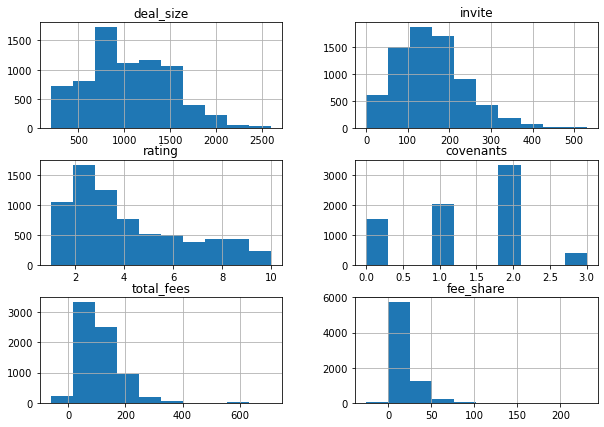

In [3]:
investor_data.hist(figsize=(10,7))
plt.show()

Look at the `total_fees` feature. Does it make sense for a client to pay negative fees? 
- No, but it looks like there are some observations with a total fees value of less than zero.

<font color = 'blue'> **EXERCISE 2.3** </font> Boolean Mask Exercise

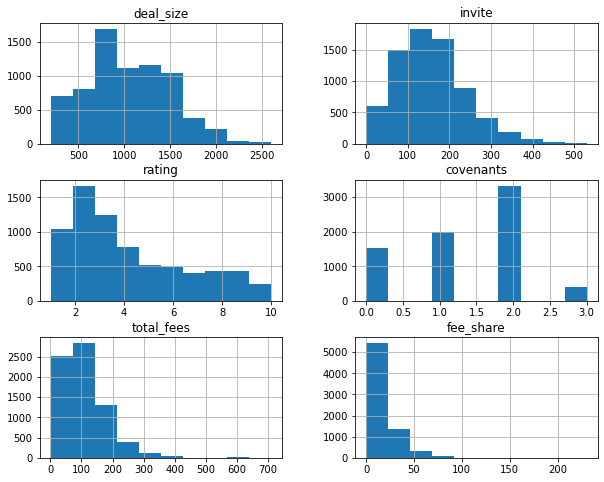

In [4]:
# includes only observations with total_fees exceeding zero
investor_data = investor_data[investor_data.total_fees > 0]

# Histogram of numeric fields
investor_data.hist(figsize=(10,8))
plt.show()

<font color = 'blue'> **EXERCISE 2.4** </font> Countplot Exercise

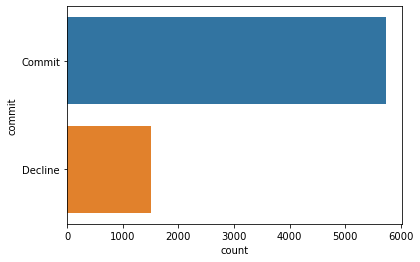

In [5]:
# Display the seaborn countplot for the 'commit' features
sns.countplot(y='commit', data=investor_data)
plt.show()

#### Comment on below - Not much differation between the investors when comparing the averages across the numeric fields

In [6]:
investor_data.groupby('investor').mean() # Display averages by investor

,deal_size,invite,rating,covenants,total_fees,fee_share
investor,,,,,,
Bank of America,1024.289581,154.905277,3.988498,1.372124,106.600135,16.247497
Deutsche Bank,1074.847043,163.670972,4.193746,1.305235,112.338545,17.498912
Goldman Sachs,1038.028169,154.985915,4.026056,1.364085,108.548592,16.348662
MUFG Union,1025.261689,156.385206,4.039079,1.379623,107.309142,16.084159
Wells Fargo,1034.521314,154.465409,4.007687,1.371768,110.321454,16.644305


In [7]:
investor_data['commit'].value_counts() # Frequency count on 'commit' column

Commit     5730
Decline    1503
Name: commit, dtype: int64

#### We're trying to predict if these investors will commit or decline a transaction. 
> - What if we asked ourselves, do banks decline the same proportion of transactions? Or, are there banks more selective than others?

In [8]:
print(type(investor_data.groupby('investor')['commit'].value_counts()))
investor_data.groupby('investor')['commit'].value_counts()

<class 'pandas.core.series.Series'>


investor         commit 
Bank of America  Commit     1247
                 Decline     231
Deutsche Bank    Commit      940
                 Decline     531
Goldman Sachs    Commit     1064
                 Decline     356
MUFG Union       Commit     1207
                 Decline     226
Wells Fargo      Commit     1272
                 Decline     159
Name: commit, dtype: int64

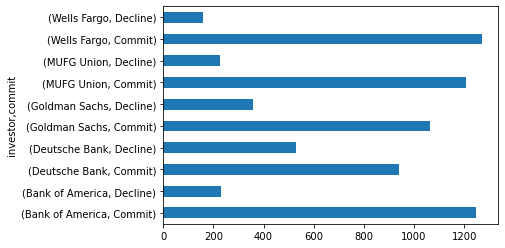

In [9]:
investor_data.groupby('investor').commit.value_counts().plot(kind='barh')
plt.show()

#### I perfer to calculate the percentage of declines in a dataframe and plot it

In [10]:
# Harry I added some more code

# groupby and unstack/transpose
InvestorCommit = investor_data.groupby('investor')['commit'].value_counts().unstack(fill_value=0)
InvestorCommit.reset_index(inplace=True) 
InvestorCommit.columns.name = None       

# Create column
InvestorCommit['Total'] = InvestorCommit['Commit'] + InvestorCommit['Decline']
InvestorCommit['Pct_Commit'] = InvestorCommit['Commit'] / (InvestorCommit['Total'])

# sort
InvestorCommit.sort_values(by='Decline', ascending=False, inplace=True) 
InvestorCommit

,investor,Commit,Decline,Total,Pct_Commit
1,Deutsche Bank,940,531,1471,0.639021
2,Goldman Sachs,1064,356,1420,0.749296
0,Bank of America,1247,231,1478,0.843708
3,MUFG Union,1207,226,1433,0.842289
4,Wells Fargo,1272,159,1431,0.888889


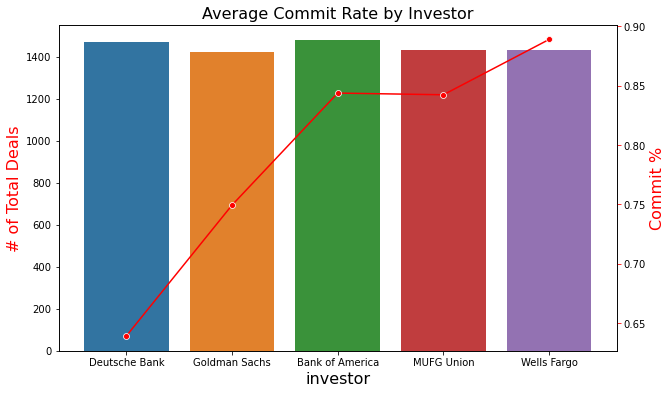

In [11]:
# Graph the dataframe

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_title('Average Commit Rate by Investor', fontsize=16)


# Declined deals
color = 'red'
ax1.set_xlabel('investor', fontsize=16)
ax2 = sns.barplot(x='investor', y='Total', data = InvestorCommit)
ax1.tick_params(axis='y')
ax1.set_ylabel('# of Total Deals', fontsize=16, color=color)
ax2 = ax1.twinx()


# Commit %
color = 'red'
ax2.set_ylabel('Commit %', fontsize=16, color=color)
ax2 = sns.lineplot(x='investor', y='Pct_Commit', data = InvestorCommit, sort=False, color=color, marker="o")
ax2.tick_params(axis='y', color=color)
plt.show()

<font color = 'blue'> **EXERCISE 2.5** </font> Group and Plot Exercise

**Comment on below** : 
1. Most of the time, these 5 investors are invited at th Bookrunner tiered, which is top tier for investor
    1. That makes sense because thse five are the most active investors in your product
2. When they're invited at the **Bookrunner** tier, it looks like these banks rarely decline a transactions
3. When they're invited at the **Participant** tier, it looks like they're much more likely to decline. 

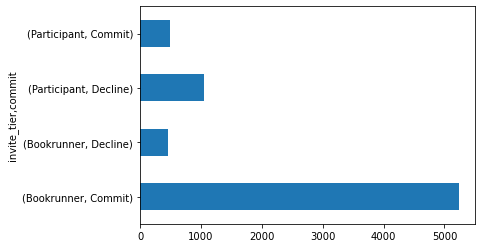

In [12]:
investor_data.groupby('invite_tier').commit.value_counts().plot(kind='barh')
plt.show()

<font color = 'blue'> **EXERCISE 2.6** </font> Tier_change Exercise

Similar to `=if()` in Excel

```python
existing_dataframe['new_series_name']=np.where(condition_to_meet, return_true_if_true, return_value_if_false)

```


In [13]:
investor_data['tier_change'] = np.where(
    investor_data.prior_tier == investor_data.invite_tier, 'None', np.where(
    investor_data.prior_tier == 'Participant', 'Promoted', 'Demoted'
    )
)

investor_data.head(3)

,investor,commit,deal_size,invite,rating,int_rate,covenants,total_fees,fee_share,prior_tier,invite_tier,tier_change
0,Goldman Sachs,Commit,300,40,2,Market,2,30,0.0,Participant,Bookrunner,Promoted
1,Deutsche Bank,Decline,1200,140,2,Market,2,115,20.1,Bookrunner,Participant,Demoted
2,Bank of America,Commit,900,130,3,Market,2,98,24.4,Bookrunner,Bookrunner,None


#### Comment on below:
1. Those who were promoted never declined
2. Whereas, those who were demoted are more like to decline

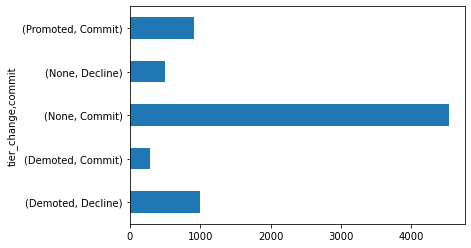

In [14]:
investor_data.groupby('tier_change').commit.value_counts().plot(kind='barh')
plt.show()

#### Comment on below
Filtering for no tier change and group them by prior tier,
> `Participant` are still about twice as likely to decline as `Bookrunners`

In [15]:
investor_data[investor_data.tier_change == 'None'].groupby('prior_tier').commit.value_counts()

prior_tier   commit 
Bookrunner   Commit     4322
             Decline     461
Participant  Commit      206
             Decline      43
Name: commit, dtype: int64

<font color = 'blue'> **EXERCISE 2.7** </font> Engineer Feature Exercise

What potentially useful features could we engineer from this?
- How about **fee share** as percentage of **total fees**?
    - It appears to be larger for commit than decline
    - Potentially, we could learn that if Goldman Sachs is getting a larger percentage of total fees, they're more likely to commit.
- How about **invite** as percentage of **deal size**?
    - It also appears to be larger for commit than decline
    - If they're invited to participate in a larger percentage of the deal size, they're also more likely to commit

In [16]:
investor_data[investor_data.investor == 'Goldman Sachs'].groupby('commit').median()

,deal_size,invite,rating,covenants,total_fees,fee_share
commit,,,,,,
Commit,1100.0,170.0,3.0,1.5,107.0,14.35
Decline,900.0,100.0,3.0,2.0,68.0,5.65


<font color = 'blue'> **EXERCISE 2.8** </font> Engineer Feature Exercise 2

- Create a new series named $\text{fee_percent}=\frac{\text{fee_share}}{\text{total_fees}} $.


- Create a new series named $\text{invite_percent }=\frac{\text{invite }}{\text{deal_size}} $.

In [17]:
investor_data['fee_percent'] = investor_data.fee_share / investor_data.total_fees
investor_data['invite_percent'] = investor_data.invite / investor_data.deal_size


##### Analyze Continuous Features' Impact on a Categorical Target

`lmplot()` allows us to create a color coded scatter plot

This will give us a sense for the total amount of investment banking fees paid out by each issuer as well as the share of those captured by the investor.
> - It looks like when investors are **getting more than 30%** of the **total fees**, they never decline.
> - It also looks like investors rarely decline when **total_fees** are greater than 200 million.

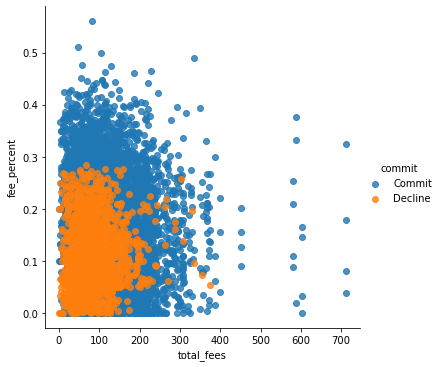

In [18]:
sns.lmplot(x='total_fees', y='fee_percent', 
           hue='commit',  # Defines cateogrical variable for color-coding
           data=investor_data, 
           fit_reg=False) # Indicates to add simple linear regression line
plt.show()

<font color = 'blue'> **EXERCISE 2.9** </font> Implot Function Exercise

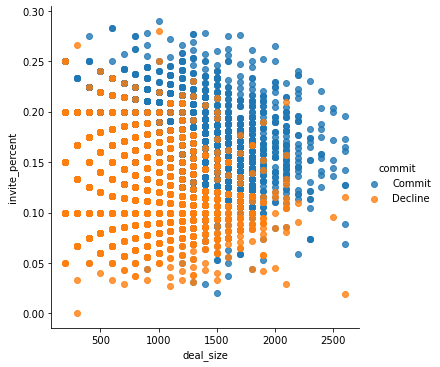

In [19]:
sns.lmplot(x='deal_size', y='invite_percent',
          hue='commit',
          data=investor_data,
          fit_reg=False)
plt.show()

### Summary of exploratory data findings - this will be used for the classification model
1. **Some banks** are more selective than others
2. It would be an anomaly if we found a **Promoted Investor** declining an invitation
3. **Demoted Investors** usually decline invitation
4. **Participants** declined more than **bookrunners**
5. Investors will probably commit to transactions where they get paid a larger amount of investment banking fees.
    1. This also applies to large share of issuer's total fees 
    2. And when committing to a large portion of those deals